In [1]:
# In this Notebook I show that converting a normal feedforward net to a FGN is easy
# Over the MNIST Dataset

In [2]:
from __future__ import print_function

In [3]:
import matplotlib as mpl
# set this 'backend' when using jupyter; do this before importing pyplot
mpl.use('nbagg')
import matplotlib.pyplot as plt

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import numpy as np
import scipy as sp
from scipy import stats
from sklearn import datasets
from sklearn.utils import shuffle as shuffle_in_unison


import sys
sys.path.append('/home/felix/Research/Adversarial Research/FGN---Research/')
import Finite_Gaussian_Network_lib as fgnl
import Finite_Gaussian_Network_lib.fgn_helper_lib as fgnh

In [5]:
!gpustat

crescent  Fri Oct 18 11:51:26 2019
[0] GeForce GTX 1080 | 54'C,   0 % |  6266 /  8119 MB | near(3377M) salami(2879M)
[1] GeForce GTX 1080 | 51'C,   3 % |   811 /  8119 MB | vietanh(799M)


In [6]:
# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
use_cuda = True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
print("Using device:", device)

# manualy set cuda device

torch.cuda.set_device(1)

CUDA Available:  True
Using device: cuda


In [7]:
# # random seeds
# torch.manual_seed(999)
# np.random.seed(999)

# torch.backends.cudnn.deterministic = True
# torch.cuda.manual_seed_all(999)

In [8]:
# load MNIST data
batch_size_for_train = 600
(mnist_train_loader, mnist_val_loader, mnist_test_loader) = fgnh.mnist_dataloaders(batch_size_for_train, 
                                                                                   batch_size_for_val=batch_size_for_train)

In [9]:
# loss functions for the classic net
lmbda_l2 = (4.0*0.1/len(mnist_train_loader.dataset))
print(lmbda_l2)
      
classical_cross_ent_loss = fgnh.def_classical_cross_ent_loss(lmbda_l2)

8e-06


In [10]:
# Initialize the classic network
hidden_layer_sizes = [256]
drop_p = 0.2
classic_model = fgnl.Feedforward_Classic_net(in_feats=28*28, out_feats=10, hidden_layer_sizes=hidden_layer_sizes, drop_p=drop_p)

classic_model.to(device)

Feedforward_Classic_net(
  (hidden_layers): ModuleList(
    (0): Dropout(p=0.2)
    (1): Linear(in_features=784, out_features=256, bias=True)
    (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2)
  )
  (ib): BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fl): Linear(in_features=256, out_features=10, bias=True)
)

In [11]:
# classic_optimizer = optim.Adam(filter(lambda p: p.requires_grad, classic_model.parameters()), lr=0.001)
classic_optimizer = optim.RMSprop(filter(lambda p: p.requires_grad, classic_model.parameters()))

In [12]:
epochs = 1

In [13]:
classic_train_res = fgnh.train(classic_model, mnist_train_loader, 
                             classical_cross_ent_loss, classic_optimizer, epochs, save_hist=2, verbose=True, 
                             pred_func=fgnh.cross_ent_pred_accuracy, test_loader=mnist_val_loader)

Epoch 0 Train set - Average loss: 0.4063, Accuracy: 43889/50000 (88%)
Test set - Average loss: 0.1951, Accuracy: 9419/10000 (94%)


In [14]:
# test over random noise

In [15]:
rand_data_loader = fgnh.mnist_random_dataloaders(num_samples=1000, batch_size=3)
x_rand = rand_data_loader.dataset.tensors[0]
x_rand = x_rand.to(device)

In [16]:
# apply model to random data
preds = classic_model(x_rand)
preds = preds.cpu().detach().numpy()
# apply softmax for probs
preds_softmax = np.array([np.exp(x)/sum(np.exp(x)) for x in preds.astype('float128')])

print(np.round(preds_softmax[:5],decimals=2))
print("shape:", preds.shape)

[[0.1  0.07 0.   0.01 0.   0.1  0.01 0.71 0.   0.  ]
 [0.01 0.01 0.   0.01 0.   0.16 0.   0.8  0.   0.  ]
 [0.02 0.02 0.   0.01 0.   0.28 0.01 0.65 0.   0.  ]
 [0.07 0.05 0.   0.01 0.   0.24 0.01 0.61 0.   0.01]
 [0.02 0.02 0.   0.02 0.   0.41 0.   0.54 0.   0.  ]]
shape: (1000, 10)


DescribeResult(nobs=1000, minmax=(0.3831260096082436461, 0.96122669561357761614), mean=0.7085027113649070214, variance=0.017034819296802233576, skewness=-0.28572506686806586424, kurtosis=-0.84700096988559700874)
percentage of confident predictions: 0.932


<IPython.core.display.Javascript object>


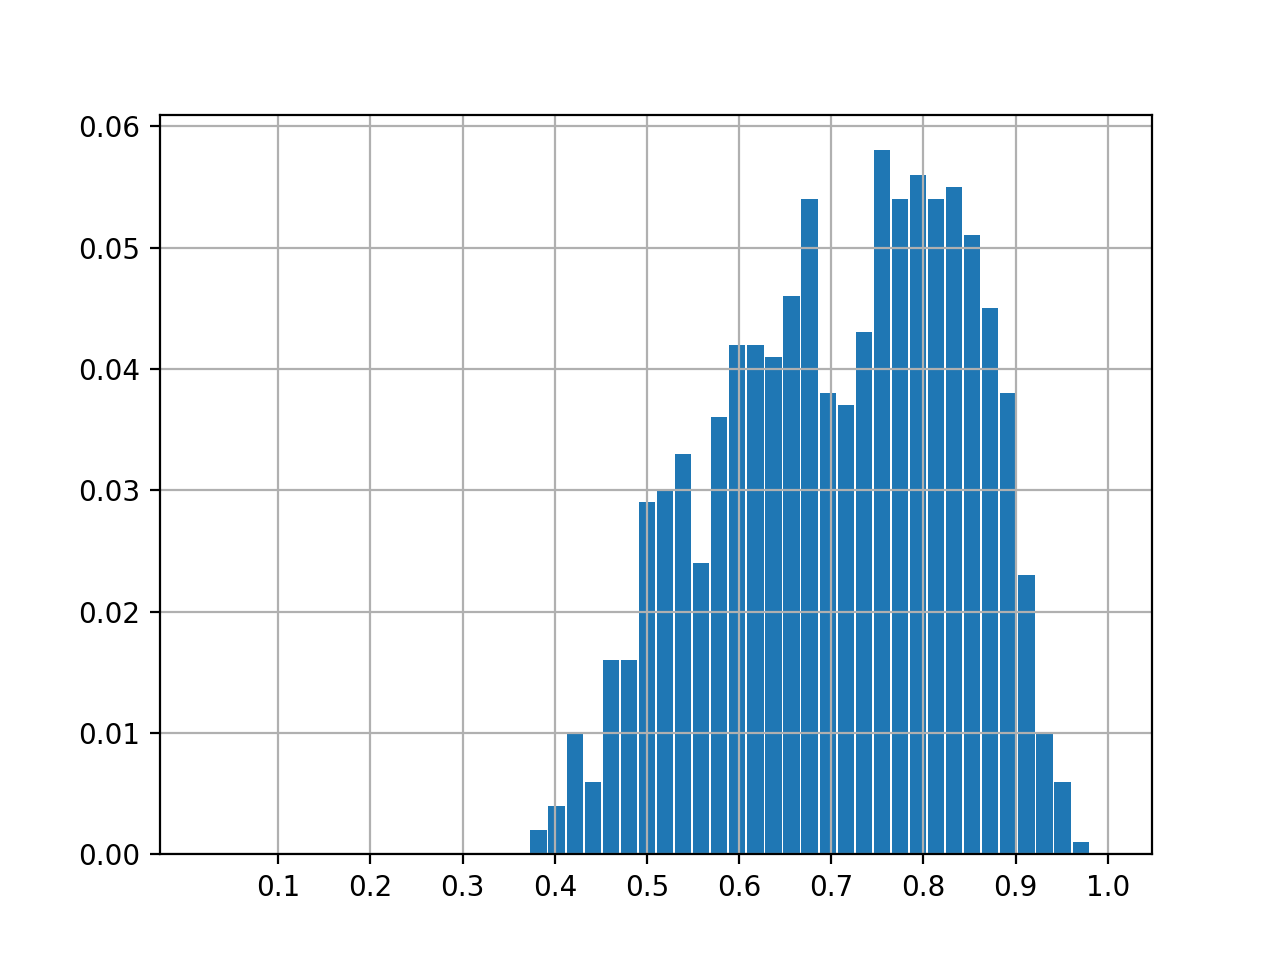

In [17]:
# quick description of the maxes
preds_maxes = np.max(preds_softmax, axis=1)
print(stats.describe(preds_maxes))
# % of maxes above 0.5
print("percentage of confident predictions:",float(len([x for x in preds_maxes if x>=0.5])/float(len(preds_maxes))))

# histogram
weights = np.ones_like(preds_maxes)/len(preds_maxes)
plt.hist(preds_maxes, bins=(np.arange(51)+1)/51.0, rwidth=0.9, align='mid', weights=weights)
plt.xticks((np.arange(10)+1)/10.0)
plt.grid(True)
plt.show()

In [18]:
### FGN NETWORK

In [19]:
# Initialize the fgn network
print("hidden layers:", hidden_layer_sizes)
print("drop prob:", drop_p)
# fgn specific params
covar_type = 'diag'
print("covariance:", covar_type)
ordinal = float(5)
print("ordinal: {0:.10f}".format(ordinal))
non_lin = True
print("non linearity:", non_lin)
free_biases = True
print("free biases:", free_biases)

hidden layers: [256]
drop prob: 0.2
covariance: diag
ordinal: 5.0000000000
non linearity: <built-in function tanh>
free biases: True


In [20]:
fgn_model = fgnl.Feedforward_FGN_net(in_feats=28*28, out_feats=10, hidden_layer_sizes=hidden_layer_sizes, drop_p=drop_p,
                                     covar_type=covar_type, ordinal=ordinal, non_lin=non_lin, free_biases=free_biases)

fgn_model.to(device)

Feedforward_FGN_net(
  (hidden_layers): ModuleList(
    (0): Dropout(p=0.2)
    (1): FGN_layer()
    (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2)
  )
  (ib): BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fl): FGN_layer()
)

In [21]:
# What is the activity of the FGN before conversion?
print("With random eval OFF")
fgn_model.set_random_eval(False)
_ = fgnh.test(fgn_model, mnist_train_loader,
                        classical_cross_ent_loss, pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

_ = fgnh.test(fgn_model, mnist_val_loader,
                        classical_cross_ent_loss, pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

print("With random eval ON")
fgn_model.set_random_eval(True)
_ = fgnh.test(fgn_model, mnist_train_loader,
                        classical_cross_ent_loss, pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

_ = fgnh.test(fgn_model, mnist_val_loader,
                        classical_cross_ent_loss, pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

With random eval OFF
Test set - Average loss: 2.8876, Accuracy: 3814/50000 (8%)
Test set - Average loss: 2.8903, Accuracy: 747/10000 (7%)
With random eval ON
Test set - Average loss: 2.8876, Accuracy: 3814/50000 (8%)
Test set - Average loss: 2.8903, Accuracy: 747/10000 (7%)


In [22]:
# convert the network
fgnl.convert_classic_to_fgn(classic_model, fgn_model)

In [23]:
# make sure performance after isnt crap
print("With random eval OFF")
fgn_model.set_random_eval(False)
_ = fgnh.test(fgn_model, mnist_train_loader,
                        classical_cross_ent_loss, pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

_ = fgnh.test(fgn_model, mnist_val_loader,
                        classical_cross_ent_loss, pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)
# switch to random eval
# shouldn't change because of the large sigma/small inv_covar
print("With random eval ON")
fgn_model.set_random_eval(True)
_ = fgnh.test(fgn_model, mnist_train_loader,
                        classical_cross_ent_loss, pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

_ = fgnh.test(fgn_model, mnist_val_loader,
                        classical_cross_ent_loss, pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

With random eval OFF
Test set - Average loss: 1.4995, Accuracy: 45082/50000 (90%)
Test set - Average loss: 1.5005, Accuracy: 9008/10000 (90%)
With random eval ON
Test set - Average loss: 1.4994, Accuracy: 45083/50000 (90%)
Test set - Average loss: 1.5007, Accuracy: 9008/10000 (90%)


In [24]:
# apply model to random data
preds = fgn_model(x_rand)
preds = preds.cpu().detach().numpy()
# apply softmax for probs
preds_softmax = np.array([np.exp(x)/sum(np.exp(x)) for x in preds.astype('float128')])

print(np.round(preds_softmax[:5],decimals=2))
print("shape:", preds.shape)

[[0.09 0.18 0.03 0.13 0.03 0.17 0.13 0.17 0.03 0.04]
 [0.09 0.18 0.03 0.13 0.03 0.17 0.13 0.17 0.03 0.04]
 [0.09 0.18 0.03 0.13 0.03 0.17 0.13 0.17 0.03 0.04]
 [0.09 0.18 0.03 0.13 0.03 0.17 0.13 0.17 0.03 0.04]
 [0.09 0.18 0.03 0.13 0.03 0.17 0.13 0.17 0.03 0.04]]
shape: (1000, 10)


DescribeResult(nobs=1000, minmax=(0.17708679041165545118, 0.17708679041165545118), mean=0.1770867904116554512, variance=1.8385484716314556869e-40, skewness=-1.0, kurtosis=-2.0)
percentage of confident predictions: 0.0


<IPython.core.display.Javascript object>


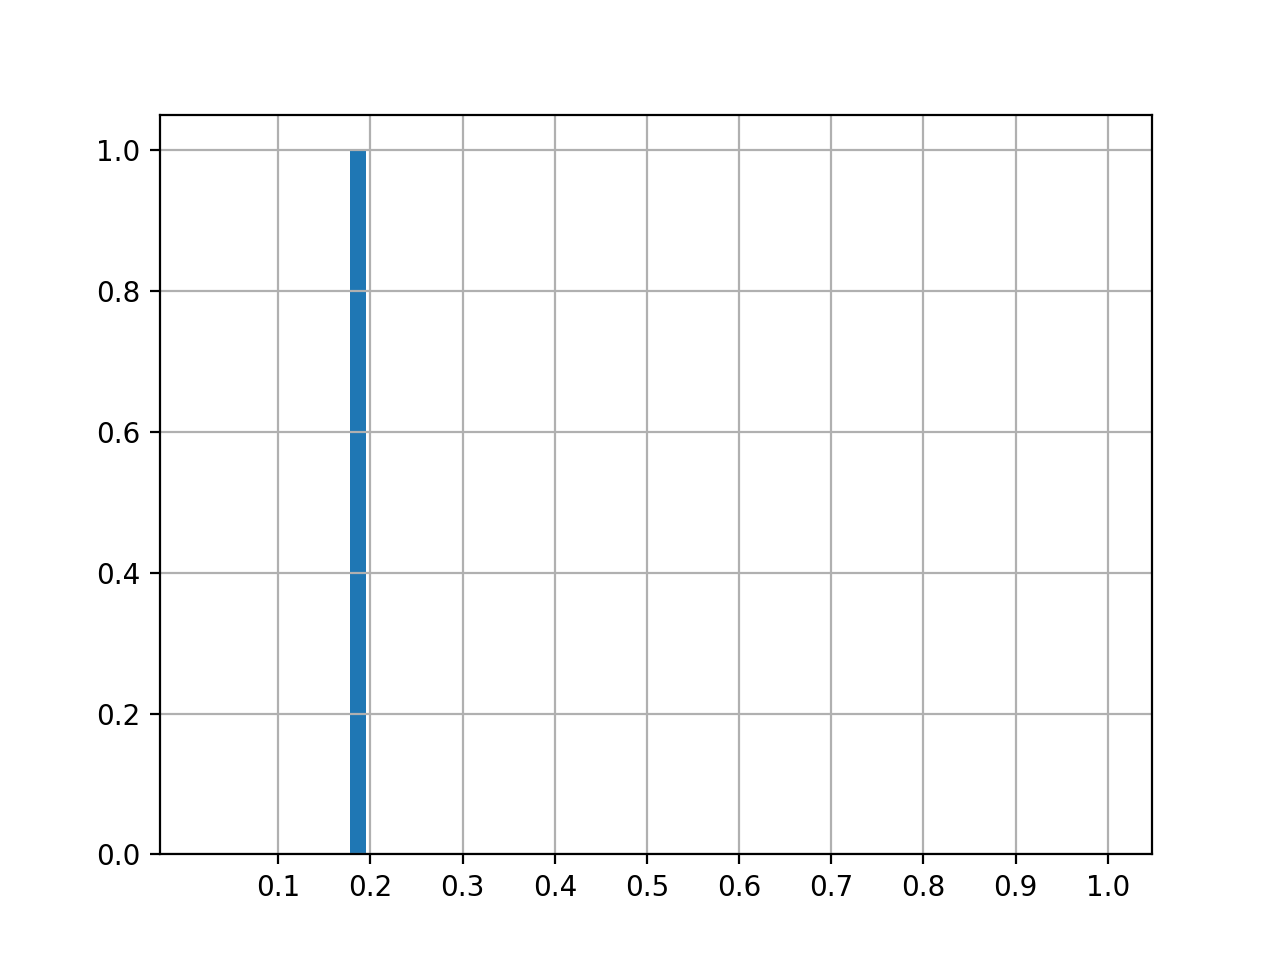

In [25]:
# quick description of the maxes
preds_maxes = np.max(preds_softmax, axis=1)
print(stats.describe(preds_maxes))
# % of maxes above 0.5
print("percentage of confident predictions:",float(len([x for x in preds_maxes if x>=0.5])/float(len(preds_maxes))))

# histogram
weights = np.ones_like(preds_maxes)/len(preds_maxes)
plt.hist(preds_maxes, bins=(np.arange(51)+1)/51.0, rwidth=0.9, align='mid', weights=weights)
plt.xticks((np.arange(10)+1)/10.0)
plt.grid(True)
plt.show()

In [26]:
### PART 2 - adjust sigmas

In [27]:
# adjusts sigmas (and maybe centers?)
# - should be fast (one epoch)
# - shouldn't impact accuracy

In [28]:
# method one: train with CENT loss for one epoch but only adjust sigmas (and centers?)

In [29]:
adjust_sigmas_optimizer = optim.Adam(zip(*filter(lambda p: p[1].requires_grad and 
                                                 ('inv_covars' in p[0] or 'centers' in p[0]), 
                                                 fgn_model.named_parameters()))[1])

# adjust_sigmas_optimizer = optim.RMSprop(zip(*filter(lambda p: p[1].requires_grad and 
#                                                  ('inv_covars' in p[0] or 'centers' in p[0]), 
#                                                  fgn_model.named_parameters()))[1])
# adjust_sigmas_optimizer = optim.Adam(filter(lambda p: p.requires_grad, fgn_model.parameters()), lr=0.001)

# adjust_sigmas_optimizer = optim.RMSprop(zip(*filter(lambda p: p[1].requires_grad and 'inv_covar' in p[0], 
#                                                  fgn_model.named_parameters()))[1])

lmbda_sigs = 1.0*lmbda_l2
adjust_sigmas_loss = fgnl.def_fgn_cross_ent_loss(lmbda_l2=1.0*lmbda_l2, lmbda_sigs=lmbda_sigs)

In [30]:
converted_train_res = fgnh.train(fgn_model, mnist_train_loader, 
                             adjust_sigmas_loss, adjust_sigmas_optimizer, epochs=1, save_hist=2, verbose=True, 
                             pred_func=fgnh.cross_ent_pred_accuracy, test_loader=mnist_test_loader)

Epoch 0 Train set - Average loss: 5.8546, Accuracy: 36556/50000 (73%)
Test set - Average loss: 1.7423, Accuracy: 7827/10000 (78%)


In [31]:
# make sure performance after isnt crap
print("With random eval OFF")
fgn_model.set_random_eval(False)
_ = fgnh.test(fgn_model, mnist_train_loader,
                        classical_cross_ent_loss, pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

_ = fgnh.test(fgn_model, mnist_val_loader,
                        classical_cross_ent_loss, pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)
# switch to random eval
# shouldn't change because of the large sigma/small inv_covar
print("With random eval ON")
fgn_model.set_random_eval(True)
_ = fgnh.test(fgn_model, mnist_train_loader,
                        classical_cross_ent_loss, pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

_ = fgnh.test(fgn_model, mnist_val_loader,
                        classical_cross_ent_loss, pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

With random eval OFF
Test set - Average loss: 1.5436, Accuracy: 39237/50000 (78%)
Test set - Average loss: 1.5273, Accuracy: 8018/10000 (80%)
With random eval ON
Test set - Average loss: 1.5457, Accuracy: 39054/50000 (78%)
Test set - Average loss: 1.5305, Accuracy: 7947/10000 (79%)


In [32]:
# # check that inv covar has gone up, sigmas down, and trace down if covar_type=='full'
# fgnl.plot_sigmas_histories(converted_train_res['histories'])

In [33]:
# # plot centers
# fgnl.plot_centers_histories(converted_train_res['histories'])

<IPython.core.display.Javascript object>


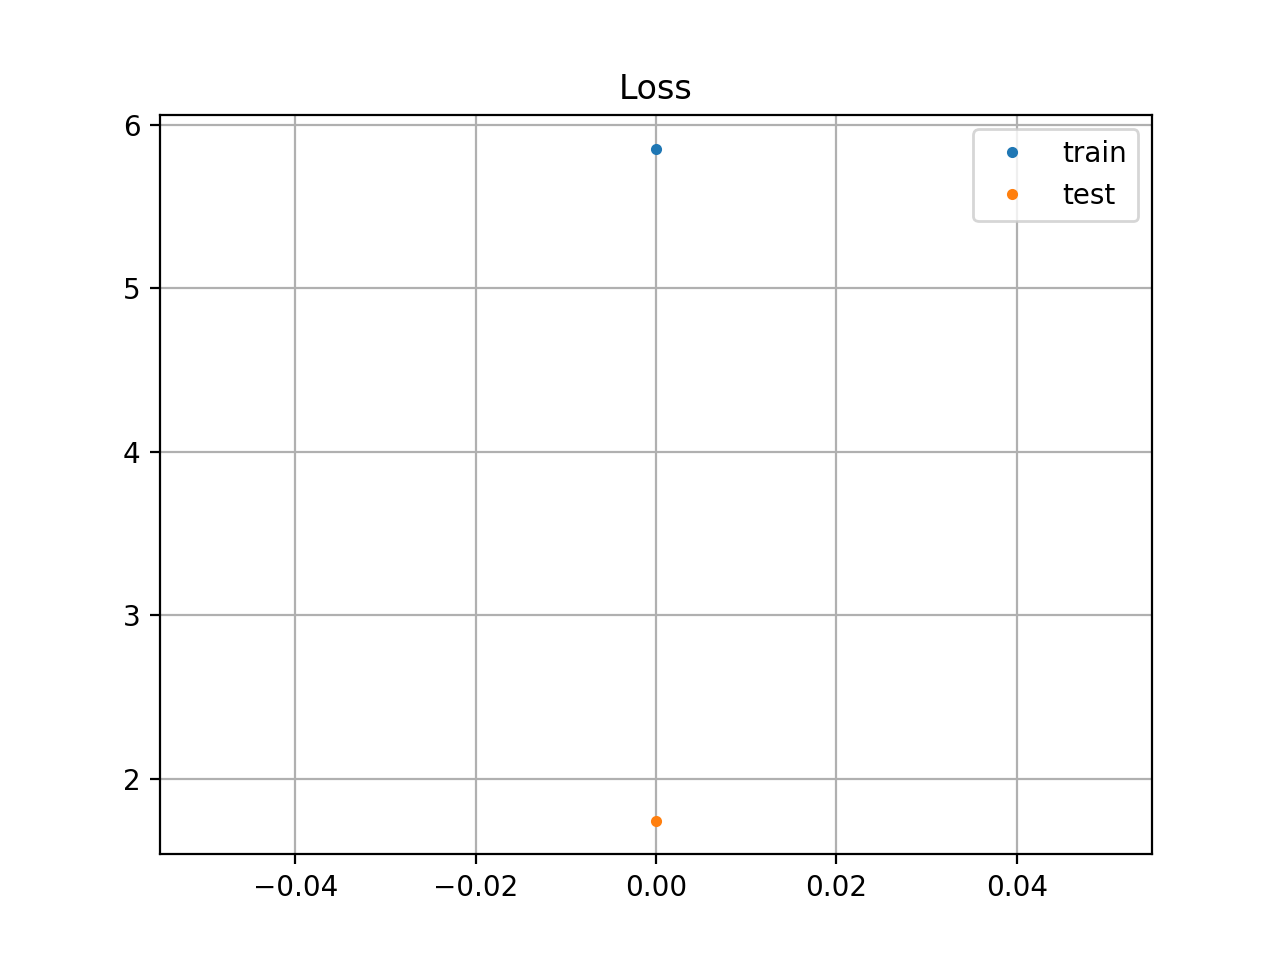

In [39]:
# acc and loss hist
plt.plot(converted_train_res['train_loss_hist'], marker='.', linestyle=' ', label='train')
plt.plot(converted_train_res['test_loss_hist'], marker='.', linestyle=' ', label='test')
plt.grid()
plt.legend()
plt.title('Loss')
plt.show()


In [34]:
# apply model to random data
preds = fgn_model(x_rand)
preds = preds.cpu().detach().numpy()
# apply softmax for probs
preds_softmax = np.array([np.exp(x)/sum(np.exp(x)) for x in preds.astype('float128')])

print(np.round(preds_softmax[:5],decimals=2))
print("shape:", preds.shape)

[[0.14 0.16 0.08 0.09 0.04 0.08 0.14 0.19 0.03 0.05]
 [0.14 0.16 0.08 0.09 0.04 0.08 0.14 0.19 0.03 0.05]
 [0.14 0.16 0.08 0.09 0.04 0.08 0.14 0.19 0.03 0.05]
 [0.14 0.16 0.08 0.09 0.04 0.08 0.14 0.19 0.03 0.05]
 [0.14 0.16 0.08 0.09 0.04 0.08 0.14 0.19 0.03 0.05]]
shape: (1000, 10)


DescribeResult(nobs=1000, minmax=(0.19332059056937230305, 0.19332059056937230305), mean=0.19332059056937230305, variance=0.0, skewness=0.0, kurtosis=-3.0)
percentage of confident predictions: 0.0


<IPython.core.display.Javascript object>


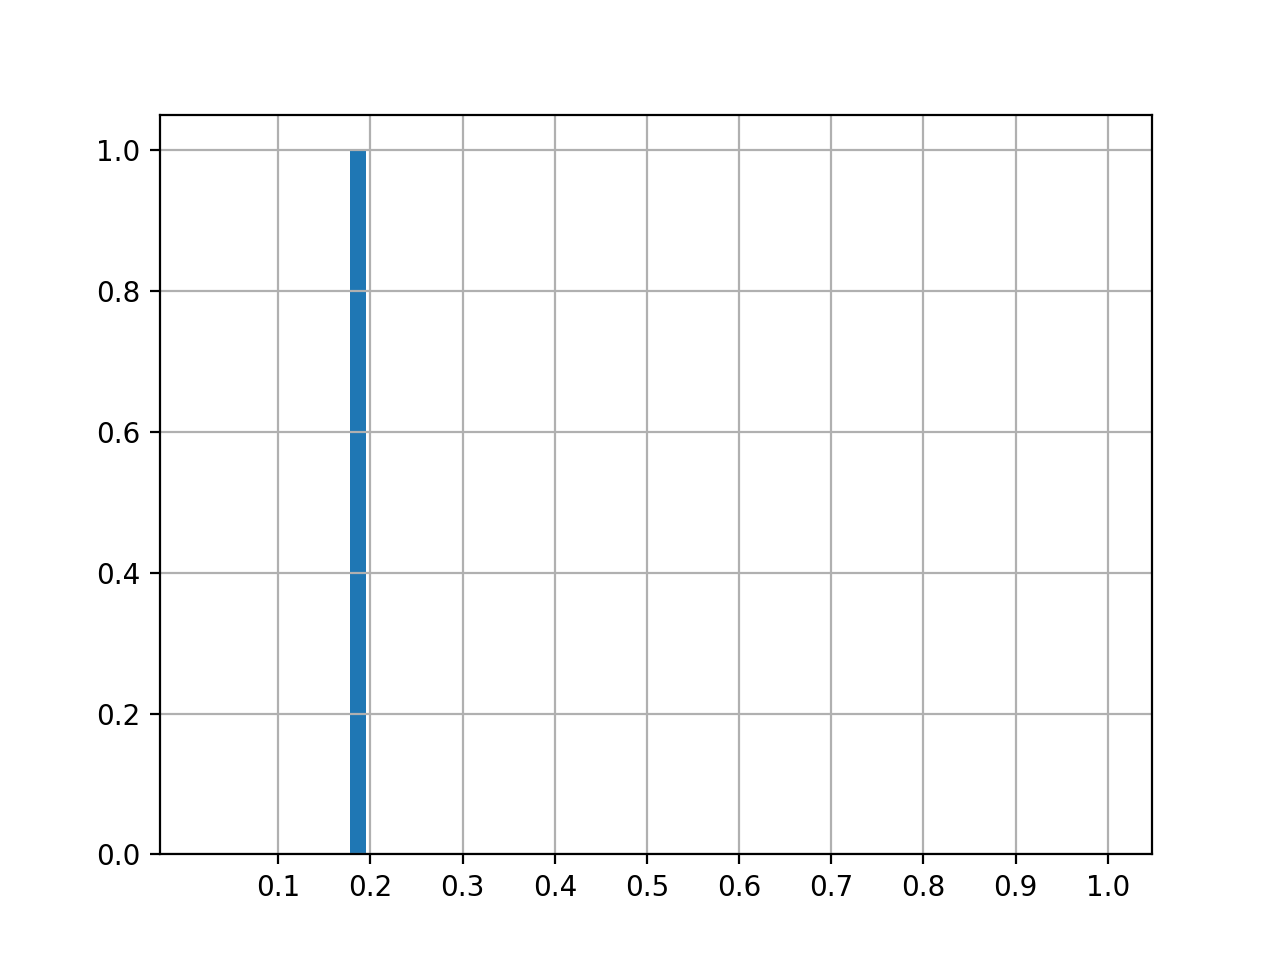

In [35]:
# quick description of the maxes
preds_maxes = np.max(preds_softmax, axis=1)
print(stats.describe(preds_maxes))
# % of maxes above 0.5
print("percentage of confident predictions:",float(len([x for x in preds_maxes if x>=0.5])/float(len(preds_maxes))))

# histogram
weights = np.ones_like(preds_maxes)/len(preds_maxes)
plt.hist(preds_maxes, bins=(np.arange(51)+1)/51.0, rwidth=0.9, align='mid', weights=weights)
plt.xticks((np.arange(10)+1)/10.0)
plt.grid(True)
plt.show()